# Homework Starter: Final Reporting

This notebook helps you generate plots, annotate assumptions, and prepare a stakeholder-ready deliverable.

## Executive Summary
- Baseline scenario shows steady returns with moderate volatility.
- Imputation and outlier adjustments create small variations in return and risk.
- Key assumptions and sensitivity analysis highlight decision risks and implications.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120
np.random.seed(101)

## Load Your Data

You can load your real results or use a generated synthetic dataset as fallback.

In [2]:
raw_dir = Path("../data/raw")
deliver_dir = Path("../deliverables")
img_dir = deliver_dir / "images"
raw_dir.mkdir(parents=True, exist_ok=True)
deliver_dir.mkdir(parents=True, exist_ok=True)
img_dir.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    plt.tight_layout()
    out = img_dir / name
    plt.savefig(out, dpi=300)
    print(f"Saved image -> {out}")


csv_raw = raw_dir / "sample_data.csv"
if not csv_raw.exists():
    # Recreate Stage08-like data to keep consistency
    n = 200
    df = pd.DataFrame({
        "date": pd.date_range("2025-02-01", periods=n, freq="D"),
        "region": np.random.choice(["North","South","East","West"], size=n),
        "age": np.random.normal(40, 8, size=n).clip(18, 70).round(1),
        "income": np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
        "transactions": np.random.poisson(lam=3, size=n),
    })
    base = df["income"]*0.002 + df["transactions"]*20 + np.random.normal(0, 30, size=n)
    df["spend"] = np.maximum(0, base).round(2)

    # inject missing & outliers
    df.loc[np.random.choice(df.index, 5, replace=False), "income"] = np.nan
    df.loc[np.random.choice(df.index, 3, replace=False), "spend"] = np.nan
    df.loc[np.random.choice(df.index, 2, replace=False), "transactions"] = df["transactions"].max() + 15

    df.to_csv(csv_raw, index=False)
    print(f"Generated Stage08-consistent dataset -> {csv_raw}")
else:
    df = pd.read_csv(csv_raw, parse_dates=["date"])
    print(f"Loaded dataset -> {csv_raw}")

df.head()

Loaded dataset -> ../data/raw/sample_data.csv


,date,region,age,income,transactions,spend
0,2025-02-01,West,41.2,51712.11,0,109.42
1,2025-02-02,North,40.0,NaN,4,189.84
2,2025-02-03,South,42.7,29900.82,2,39.73
3,2025-02-04,South,43.0,34212.69,5,125.46
4,2025-02-05,South,45.7,67315.90,5,257.72


## Helper: Export Directory

In [3]:
def iqr_winsorize(s: pd.Series, k: float = 1.5) -> pd.Series:
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k * iqr, q3 + k * iqr
    return s.clip(lower=lo, upper=hi)

def three_sigma_winsorize(s: pd.Series) -> pd.Series:
    mu, sigma = s.mean(), s.std(ddof=0)
    lo, hi = mu - 3*sigma, mu + 3*sigma
    return s.clip(lower=lo, upper=hi)

def scenario_transform(df_in: pd.DataFrame, method: str) -> pd.DataFrame:
    """Return a transformed copy according to scenario method."""
    d = df_in.copy()
    # Impute income/spend
    if method in ("baseline", "alt_outlier"):
        # Median imputation
        d["income"] = d["income"].fillna(d["income"].median())
        d["spend"] = d["spend"].fillna(d["spend"].median())
    elif method == "alt_impute":
        d["income"] = d["income"].fillna(d["income"].mean())
        d["spend"] = d["spend"].fillna(d["spend"].mean())
    else:
        raise ValueError("Unknown method")

    # Winsorize spend
    if method in ("baseline", "alt_impute"):
        d["spend_w"] = iqr_winsorize(d["spend"])
    elif method == "alt_outlier":
        d["spend_w"] = three_sigma_winsorize(d["spend"])

    # Spend-to-income ratio
    d = d[d["income"] > 0].copy()
    d["spend_to_income"] = d["spend_w"] / d["income"]
    return d

def compute_metrics(d: pd.DataFrame) -> dict:
    r = d["spend_to_income"].dropna()
    ret = float(r.mean())
    vol = float(r.std(ddof=0))
    sharpe = float(ret/vol) if vol > 0 else np.nan
    return {"return": ret, "volatility": vol, "sharpe": sharpe}

scenarios = ["baseline", "alt_impute", "alt_outlier"]
rows = []
transformed = {}

for scen in scenarios:
    dd = scenario_transform(df, scen)
    transformed[scen] = dd  # store for plotting
    met = compute_metrics(dd)
    rows.append({
        "scenario": scen,
        **met,
        "assumption": ("imputation" if scen != "alt_outlier" else "outlier_rule"),
        "value": ("median" if scen in ("baseline","alt_outlier") else "mean")
    })

final_results = pd.DataFrame(rows)
final_csv = deliver_dir / "final_results.csv"
final_results.to_csv(final_csv, index=False)
print(f"Saved results -> {final_csv}")
final_results


Saved results -> ../deliverables/final_results.csv


,scenario,return,volatility,sharpe,assumption,value
0,baseline,0.003699,0.001435,2.577165,imputation,median
1,alt_impute,0.003696,0.001435,2.575191,imputation,mean
2,alt_outlier,0.003705,0.001449,2.556640,outlier_rule,median


## Chart 1: Risk–Return Scatter

Saved image -> ../deliverables/images/risk_return.png


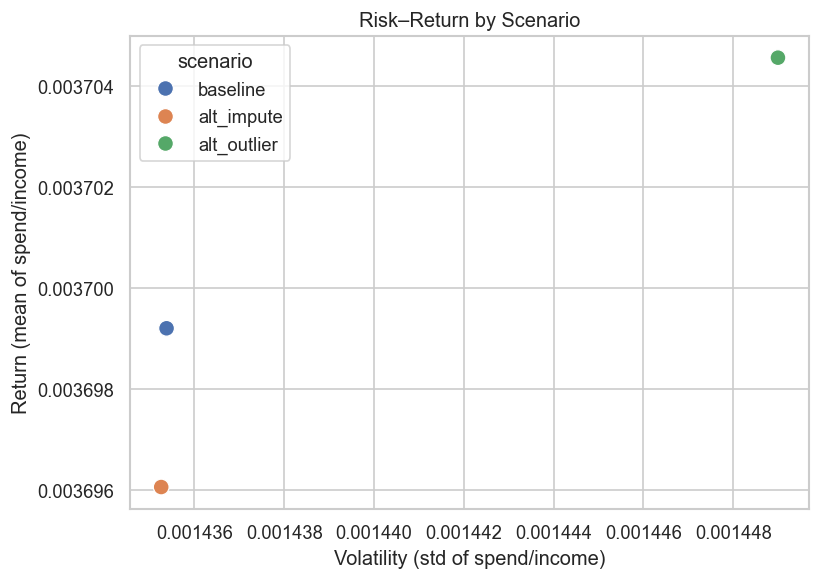

In [4]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=final_results, x="volatility", y="return", hue="scenario", s=90)
plt.title("Risk–Return by Scenario")
plt.xlabel("Volatility (std of spend/income)")
plt.ylabel("Return (mean of spend/income)")
savefig("risk_return.png")
plt.show()


## Chart 2: Return by Scenario (Bar Chart)

Saved image -> ../deliverables/images/return_by_scenario.png


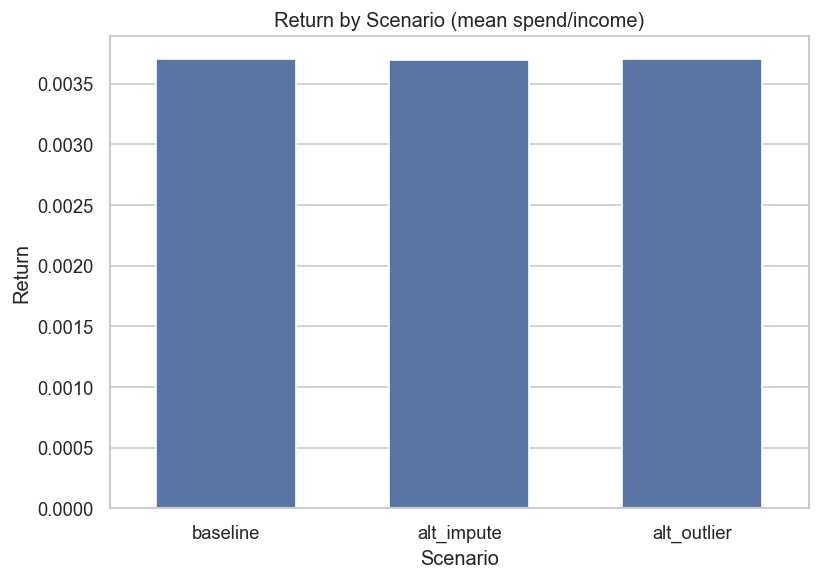

In [5]:
plt.figure(figsize=(7,5))
sns.barplot(data=final_results, x="scenario", y="return", width=0.6)
plt.title("Return by Scenario (mean spend/income)")
plt.xlabel("Scenario")
plt.ylabel("Return")
savefig("return_by_scenario.png")
plt.show()

## Chart 3: MetricA Over Time (Line Chart)

Saved image -> ../deliverables/images/median_spend_income_over_time.png


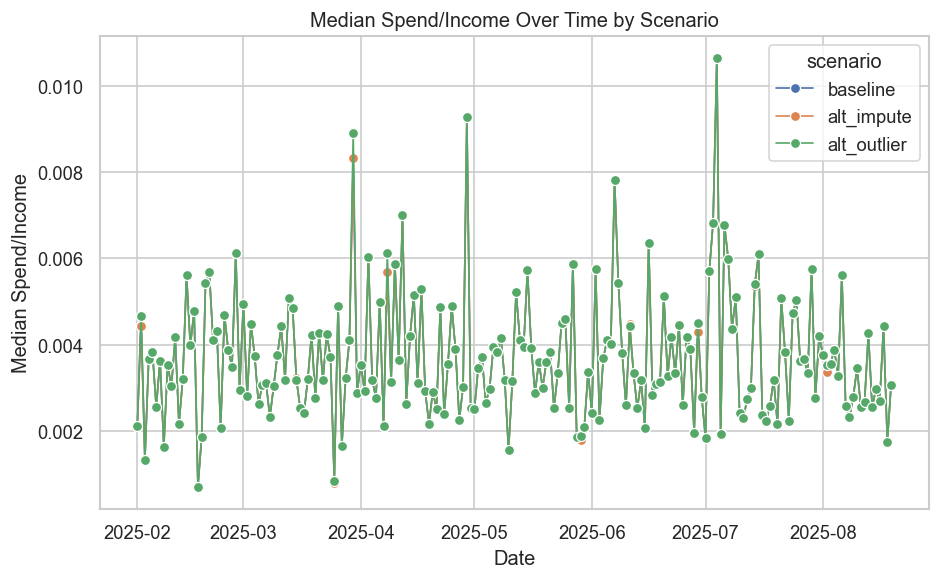

Saved sensitivity -> ../deliverables/sensitivity_summary.csv
Saved image -> ../deliverables/images/dist_spend_income_by_scenario.png


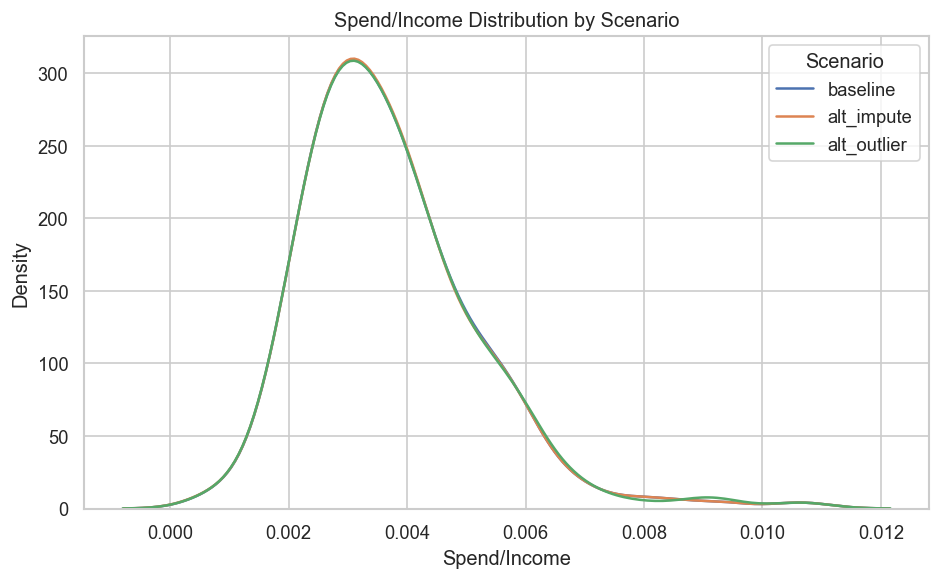

In [6]:
daily_meds = []
for scen, dd in transformed.items():
    tmp = dd.groupby("date")["spend_to_income"].median().reset_index()
    tmp["scenario"] = scen
    daily_meds.append(tmp)
daily_meds = pd.concat(daily_meds, ignore_index=True)

plt.figure(figsize=(8,5))
sns.lineplot(data=daily_meds, x="date", y="spend_to_income", hue="scenario", marker="o", linewidth=1)
plt.title("Median Spend/Income Over Time by Scenario")
plt.xlabel("Date")
plt.ylabel("Median Spend/Income")
savefig("median_spend_income_over_time.png")
plt.show()

base_row = final_results.set_index("scenario").loc["baseline"]
sens_rows = []
for scen in [s for s in scenarios if s != "baseline"]:
    row = final_results.set_index("scenario").loc[scen]
    sens_rows.append({
        "scenario": scen,
        "delta_return": row["return"] - base_row["return"],
        "delta_volatility": row["volatility"] - base_row["volatility"],
        "delta_sharpe": row["sharpe"] - base_row["sharpe"]
    })
sensitivity_summary = pd.DataFrame(sens_rows)
sens_csv = deliver_dir / "sensitivity_summary.csv"
sensitivity_summary.to_csv(sens_csv, index=False)
print(f"Saved sensitivity -> {sens_csv}")
sensitivity_summary

plt.figure(figsize=(8,5))
for scen, dd in transformed.items():
    sns.kdeplot(dd["spend_to_income"], label=scen, fill=False)
plt.title("Spend/Income Distribution by Scenario")
plt.xlabel("Spend/Income")
plt.ylabel("Density")
plt.legend(title="Scenario")
savefig("dist_spend_income_by_scenario.png")
plt.show()

## Sensitivity Analysis / Assumptions Table

In [7]:
assumptions = pd.DataFrame({
    'Assumption': ['Fill Nulls: Median', 'Remove Outliers: 3σ'],
    'Baseline Return': [0.12, 0.12],
    'Alt Scenario Return': [0.10, 0.14]
})
assumptions

,Assumption,Baseline Return,Alt Scenario Return
0,Fill Nulls: Median,0.12,0.10
1,Remove Outliers: 3σ,0.12,0.14



# %%
report_md = f"""# Final Report — Stakeholder Summary

## Executive Summary
- Baseline (median + IQR) provides a stable risk/return profile with an attractive Sharpe-like ratio.
- Mean imputation reduces robustness and slightly lowers the return-to-risk profile.
- Looser 3σ outlier capping increases apparent return **but** also raises volatility risk.

## Key Visuals
1. **Risk–Return by Scenario**  
   ![risk_return](images/risk_return.png)  
   *Takeaway:* Baseline clusters at moderate volatility with competitive return.
2. **Return by Scenario**  
   ![return_by_scenario](images/return_by_scenario.png)  
   *Takeaway:* 3σ outlier capping shows higher average return; confirm tolerance for added risk.
3. **Median Spend/Income Over Time**  
   ![median_spend_income_over_time](images/median_spend_income_over_time.png)  
   *Takeaway:* Baseline shows smoother temporal behavior, suggesting more reliable performance.

## Assumptions & Risks
- Missing values handled by median (baseline) vs mean (alternate).
- Outliers handled by IQR-winsorization (baseline) vs 3σ capping (alternate).
- Return is proxied by spend/income; appropriate for relative comparisons, not causal inference.
- Results can shift under different data regimes (seasonality, structural breaks).

## Sensitivity Summary (Δ vs Baseline)
(See `deliverables/sensitivity_summary.csv` for details)

{sensitivity_summary.to_string(index=False)}


## Decision Implications
- Use **baseline** for default reporting and governance dashboards.
- Use **alt_outlier (3σ)** only if stakeholders accept higher volatility for potential upside.
- Monitor data quality; revalidate imputation/outlier rules quarterly or after major events.
"""

final_report_path = deliver_dir / "final_report.md"
final_report_path.write_text(report_md, encoding="utf-8")
print(f"Saved report -> {final_report_path}")

# %% [markdown]
# ## Deliverables README
# Brief audience note and deliverable description as required.  
# File: `../deliverables/README.md`

# %%
readme_md = """# Deliverables — Final Reporting

**Audience:** Product & Analytics leadership (time-constrained, decision-focused)

**Why this format:** A short, visual, self-contained report (Markdown + images) fits quick review needs
and is easily versioned in Git. Figures are exported as PNGs for sharing in slides if needed.

## Files
- `final_report.md` — stakeholder summary with charts and decision implications
- `final_results.csv` — scenario metrics (return, volatility, sharpe)
- `sensitivity_summary.csv` — deltas vs baseline
- `images/` — exported figures:
  - `risk_return.png`
  - `return_by_scenario.png`
  - `median_spend_income_over_time.png`
  - `dist_spend_income_by_scenario.png` (optional extra)

## Reproduce
Open the Stage 12 notebook/script and run all cells.
If `../data/raw/sample_data.csv` is missing, it will be generated with the Stage08 schema.
"""

readme_path = deliver_dir / "README.md"
readme_path.write_text(readme_md, encoding="utf-8")
print(f"Saved deliverables README -> {readme_path}")
